# Analytical Research For a Telecommunication Company

Telecom company Megaline was launched in the end of 2017. It offers two tariffs: Smat and Ultra. 
We have to make analysis according to the results of the year.

**The purpose of the analysis:**
1. It is necessary to analyze users behavior  and draw a conclusion - which tariff brings more revenue.

2. Also company managment asks to chek if the average user in Moscow generates more revenue than regional user.

**Data sets -** inner data based on a sample of 500 users:
- user information,
- call information,
- information about messages,
- information about internet sessions,
- information about tariffs.

**Tariff Description**

_Tariff "Smart":_
1. Monthly fee: 550 rubles
2. Included 500 minutes of talk, 50 messages and 15 GB of internet traffic
3. The cost of services above the tariff package:
    - minute of conversation: 3 rubles
    - message: 3 rubles
    - 1 GB of Internet traffic: 200 rubles

_Tariff "Ultra":_
1. Monthly fee: 1950 rubles
2. Included 3000 minutes of calls, 1000 messages and 30 GB of internet traffic
3. The cost of services above the tariff package:
    - minute of conversation: 1 ruble
    - message: 1 ruble
    - 1 GB of Internet traffic: 150 rubles

<mark style="background-color: grey">
**Note**
Megaline always rounds seconds to minutes, and megabytes to gigabytes. Each call is rounded up separately: even if it lasted only 1 second, it will be counted as 1 minute.
For web traffic, individual sessions are not counted. Instead, the monthly total is rounded up. If a subscriber uses 1025 megabytes this month, they will be charged for 2 gigabytes. Accept that unused calls, SMS, Internet for the previous month are not transferred to the next month.

**Contents:**
1. [Data overview and preprocessing](#1)
    - [Calls dataset](#1.1)
    - [Internet dataset](#1.2)
    - [Message dataset](#1.3)
    - [Tariffs dataset](#1.4)
    - [Users dataset](#1.5)
    
2. [Let's have a look at our clients](#2)
    - [How many users do we have?](#2.1)
    - [What ages are represented?](#2.2)
    - [Where do our users live?](#2.3)
    - [Calculations to explore our users behavior.](#2.4)
    - [How our customers use their connection?](#2.5)
    - [](#2.6)
3. [What is our revenue?](#3)
4. [Let's check the hipotesis.](#4)
    - [Does income between tariffs is different?](#4.1)
    - [Does income between Moscow and other regions is different?](#4.2)

5. [General conclusions](#5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math
from io import BytesIO
import requests
import statistics
import datetime as dt
import matplotlib

pd.set_option('display.float_format', '{:,.1f}'.format)
sns.set_style('white')
matplotlib.rcParams.update({'font.size': 12})

#set the color for further plots
colors = {"smart": '#F2C8A2', "ultra": '#8091F2'}

<a id="1"></a>

# 1. Data overview and preprocessing

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
message = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

<a id="1.1"></a>

## Calls dataset

In [3]:
print(calls.shape)
print('Duplicated rows', calls.duplicated().sum())
print(calls.info())
calls.head()

(202607, 4)
Duplicated rows 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,2.9,1000
3,1000_3,2018-09-21,13.8,1000
4,1000_4,2018-12-15,5.2,1000


__Amendments to be done:__
1. We'll change data type in column 'call_date' into DateTime.
2. We'll have to add a column with rounded duration of calls.
3. User id has the same format and type as in 'users' dataset.

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [5]:
calls['min_used'] = calls['duration'].apply(math.ceil)

In [6]:
calls['month'] = calls['call_date'].dt.month

In [7]:
print('Calls data are avaliable from {} to {}' .format(calls['call_date'].min(), calls['call_date'].max()))

Calls data are avaliable from 2018-01-01 00:00:00 to 2018-12-31 00:00:00


<a id="1.2"></a>

## Internet dataset

In [8]:
print(internet.shape)
print('Duplicated rows', internet.duplicated().sum())
print(internet.info())
internet.head()

(149396, 5)
Duplicated rows 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113.0,2018-11-25,1000
1,1,1000_1,"1,052.8",2018-09-07,1000
2,2,1000_2,"1,197.3",2018-06-25,1000
3,3,1000_3,550.3,2018-08-22,1000
4,4,1000_4,302.6,2018-09-24,1000


__Amendments to be done:__
1. Delete collumn 'Unnamed:0' that duplicates index column.
2. Change data type of column 'session_date' into DateTime.
3. After joining whith Users-Tarifs datasets we'll have to add a column with rounded md uset for whole month.

In [9]:
internet =  internet.loc[:, ['id', 'mb_used', 'session_date', 'user_id']]

internet['session_date'] = pd.to_datetime(internet['session_date'])

In [10]:
internet['month'] = internet['session_date'].dt.month

In [11]:
print('Calls data are avaliable from {} to {}' .format(internet['session_date'].min(), internet['session_date'].max()))

Calls data are avaliable from 2018-01-01 00:00:00 to 2018-12-31 00:00:00


<a id="1.3"></a>

## Message dataset

In [12]:
print(message.shape)
print('Duplicated rows', message.duplicated().sum())
print(message.info())
message.head()

(123036, 3)
Duplicated rows 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


__Amendments to be done:__
1. Change data type of column 'message_date' into DateTime.

In [13]:
message['message_date'] = pd.to_datetime(message['message_date'])

In [14]:
message['month'] = message['message_date'].dt.month

In [15]:
print('Calls data are avaliable from {} to {}' .format(message['message_date'].min(), message['message_date'].max()))

Calls data are avaliable from 2018-01-02 00:00:00 to 2018-12-31 00:00:00


<a id="1.4"></a>

## Tariffs dataset

In [16]:
print(tariffs.info())
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<a id="1.5"></a>

## Users dataset

In [17]:
print(users.shape)
print('Duplicated rows:', users.loc[:,['age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff']].duplicated().sum())
print(users.info())

users.head()

(500, 8)
Duplicated rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


__Amendments to be done:__
1. Change data type of columns 'reg_date' and 'churn_date' into DateTime.
2. For further comfortable analisys we should merge 'users' dataset with 'tariffs' dataset. 

In [18]:
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

In [19]:
users = users.merge(tariffs, left_on='tariff', right_on = 'tariff_name') 

<a id="2"></a>

# 2. Let's have a look at our clients

<a id="2.1"></a>

## How many users do we have?

In [20]:
print('Smart tariff users:{} ({:.1%})' .format(users.query('tariff == "smart"')['user_id'].count(), 
                                               users.query('tariff == "smart"')['user_id'].count() / users['user_id'].count()))

print('Ultra tariff users:{} ({:.1%})' .format(users.query('tariff == "ultra"')['user_id'].count(),
                                              users.query('tariff == "ultra"')['user_id'].count() / users['user_id'].count()))

Smart tariff users:351 (70.2%)
Ultra tariff users:149 (29.8%)


In [21]:
# Let's add column with clients lifetime
def lifetime(df):
    i = df['churn_date']
    y = df['reg_date']
    date = dt.datetime.strptime('31/12/18', '%d/%m/%y')
    if i<date:
        return (i - y)/ np.timedelta64(1, 'M')
    else:
        return (date - y)/ np.timedelta64(1, 'M')

users['lifetime'] = users.apply(lifetime, axis=1)

In [22]:
users.query('lifetime < 1').value_counts('tariff')

tariff
smart    29
ultra     8
dtype: int64

We have 8% (smart) and 5% (ultra) clients who had used tariffs less than a month. Lets delete them as they aren't illustrative.

In [23]:
users = users.query('lifetime >= 1')

In [24]:
print('Smart tariff users:{} ({:.1%})' .format(users.query('tariff == "smart"')['user_id'].count(), 
                                               users.query('tariff == "smart"')['user_id'].count() / users['user_id'].count()))

print('Ultra tariff users:{} ({:.1%})' .format(users.query('tariff == "ultra"')['user_id'].count(),
                                              users.query('tariff == "ultra"')['user_id'].count() / users['user_id'].count()))

Smart tariff users:322 (69.5%)
Ultra tariff users:141 (30.5%)


<a id="2.2"></a>

## What ages are represented?

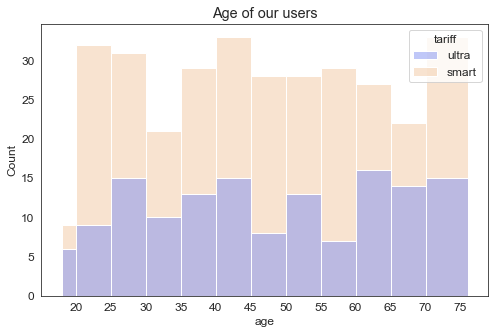

Age range of our users 18-75


In [25]:
plt.figure(figsize=(8,5))
sns.histplot(data=users, x='age', bins=[18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 76], hue='tariff', palette = colors)
plt.xticks(np.arange(20, 80, step=5))
plt.title('Age of our users')
plt.show()

print('Age range of our users {}-{}' .format(users['age'].min(), users['age'].max()))

It looks like there are represented users of all the age groups in our sample.

<a id="2.3"></a>

## Where do our users live?

In [26]:
# uploading of regions as list of cities doesn't show a full picture
spreadsheet_id = '1sDGPF88gjC_gLoV95M4aEYUvpHjkccVIk_UWYHKRs28'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
cities = pd.read_csv(BytesIO(r.content))
cities
cities = cities.loc[:, ['city', 'region']]

users = users.merge(cities, on='city', how='left')

# surwey if all of the cities has their own region 
users[users['region'].isnull()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,lifetime,region


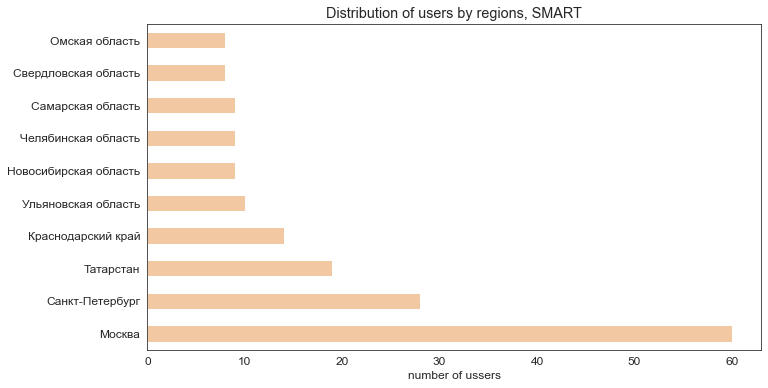

In [27]:
fig = plt.figure(figsize=(11, 6))
users.query('tariff =="smart"')['region'].value_counts().head(10).plot(kind='barh', color=colors['smart'])
plt.title('Distribution of users by regions, SMART')
plt.xlabel('number of ussers')
plt.show()

**Distribution of the clients looks similar to population distribution by regions.**

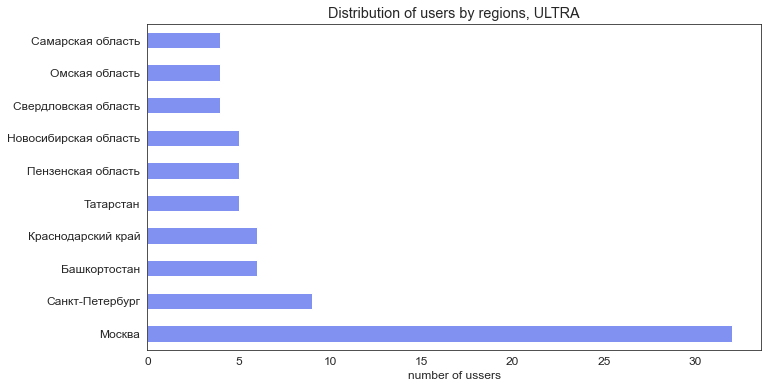

In [28]:
fig = plt.figure(figsize=(11, 6))
users.query('tariff =="ultra"')['region'].value_counts().head(10).plot(kind='barh', color=colors['ultra'])
plt.title('Distribution of users by regions, ULTRA')
plt.xlabel('number of ussers')
plt.show()

Sample of Ultra tariff users has more members from Moscow region. As far as the sample is random we can conduct that it's distribution is similar to the distribution of all population. 
**Thus we can make inference that more than 21% of all Ultra users based in Moscow.** I guess the reason is that Moscow citizens have bigger income.


<a id="2.4"></a>

## Calculations to explore our users behavior.

In [29]:
# sum all calls, megabytes and messages
month_calls = calls.groupby(['user_id', 'month']).agg({'min_used':'sum'}).reset_index()

month_internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()

month_messages = message.groupby(['user_id', 'month'])['id'].count().reset_index()
month_messages.rename(columns={'id': 'messages'}, inplace = True)

In [30]:
# merge our previous calculations and users data set
data = month_calls.merge(month_internet, on = ['user_id', 'month'], how='outer')\
                  .merge(month_messages, on = ['user_id', 'month'], how='outer')

data = users.merge(data, on='user_id', how='left')

In [31]:
# convert mbs in gbs
data['gb_used'] = data['mb_used'] / 1024

In [32]:
# calculate ammount of all calls and non-zero calls
calls_count = calls.groupby(['user_id', 'month'])['duration'].count().reset_index()
calls_count.rename(columns = {'duration': 'n_all_calls'}, inplace = True)

calls_count = calls_count.merge(calls.query('duration != 0').groupby(['user_id', 'month'])['duration'].count(),
                                left_on=['user_id', 'month'], right_index=True)
calls_count.rename(columns = {'duration': 'non_0_calls'}, inplace = True)

data = data.merge(calls_count, on = ['user_id', 'month'], how='left')

In [33]:
def gb_extra(row):
    """extra gb calculations"""
    x = row['mb_used'] 
    i = row['mb_per_month_included']
    if x > i:
        return math.ceil((x-i) / 1024)
    else:
        return 0

data['gb_extra'] = data.apply(gb_extra, axis=1)

In [34]:
def minutes_extra(row):
    """extra calls calculations"""
    x = row['min_used']
    i = row['minutes_included']
    if x > i:
        return x-i
    else:
        return 0

data['minutes_extra'] = data.apply(minutes_extra, axis=1)

In [35]:
def messages_extra(row):
    """extra sms calculation"""
    x = row['messages']
    i = row['messages_included']
    if x > i:
        return x-i
    else:
        return 0

data['messages_extra'] = data.apply(messages_extra, axis=1)

In [36]:
data['extra_fee'] = (data['gb_extra'] * data['rub_per_gb'] +
                     data['minutes_extra'] * data['rub_per_minute'] +
                     data['messages_extra'] * data['rub_per_message'])

data['total_fee'] = data['rub_monthly_fee'] + data['extra_fee']

In [37]:
hist_df = data.pivot_table(index = ['user_id', 'tariff_name'], 
                           values = ['age', 'tariff', 'min_used', 'messages', 'gb_used', 'non_0_calls', 'total_fee'], 
                           aggfunc = 'mean').reset_index()

def distribution(column):
    """draws KDE plot, boxplot and and displays statistics"""

    table = pd.DataFrame([
    [hist_df[column].median(), hist_df.query('tariff_name == "smart"')[column].median(),hist_df.query('tariff_name == "ultra"')[column].median()],\
    [hist_df[column].mean(), hist_df.query('tariff_name == "smart"')[column].mean(), hist_df.query('tariff_name == "ultra"')[column].mean()],\
    [statistics.stdev(hist_df[hist_df[column].isna() == False][column]), statistics.stdev(hist_df[(hist_df['tariff_name']=='smart') & (hist_df[column].isna() == False)][column]), statistics.stdev(hist_df[(hist_df['tariff_name']=='ultra') & (hist_df[column].isna() == False)][column])],\
    ])
        
    table.columns = ['Total', 'SMART', 'ULTRA']
    table.index = ['median', 'mean', 'st.dev']
    display(table)
        
    fig = plt.figure(figsize=(15, 3))
        
    ax_1 = fig.add_subplot(1, 2, 1)
    sns.kdeplot(hist_df.query('tariff_name == "smart"')[column], shade=True, alpha = 0.5, label='smart', color=colors['smart'])
    plt.axvline(hist_df.query('tariff_name == "smart"')[column].mean(), linestyle='--', color=colors['smart'])
    sns.kdeplot(hist_df.query('tariff_name == "ultra"')[column], shade=True, alpha = 0.5, label='ultra', color=colors['ultra'])
    plt.axvline(hist_df.query('tariff_name == "ultra"')[column].mean(), linestyle='--', color=colors['ultra'])
    plt.legend()
    plt.title(column)
        
    ax_1 = fig.add_subplot(1, 2, 2)
    sns.boxplot(data=hist_df, x=column, y='tariff_name', hue='tariff_name', palette=colors)
    plt.legend()
    plt.title(column)
    plt.show()
    
    print("Amount of users who don't utilize this service: SMART - {}, ULTRA - {}"
         .format(hist_df[hist_df['tariff_name'] == 'smart'][column].isna().sum(),
                hist_df[hist_df['tariff_name'] == 'ultra'][column].isna().sum()))

<a id="2.5"></a>

## How our customers use their connection?

**CALLS:**

,Total,SMART,ULTRA
median,443.2,425.2,520.4
mean,454.8,419.0,539.1
st.dev,196.2,143.2,266.8


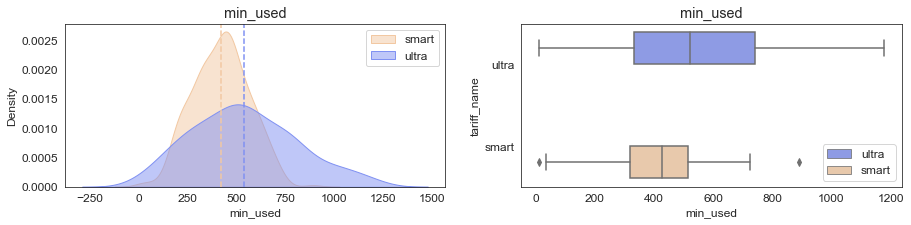

Amount of users who don't utilize this service: SMART - 1, ULTRA - 5


In [38]:
distribution('min_used')

Tariff plans include 500 min(SMART) and 3000(ULTRA)

**Calls:** 
1. SMART
    - A half of smart users uses less than 425 minutes per month, 
    - Another quarter uses 425-515 minutes, 
    - 760 minutes would be exhaustively for the wast majority of the rest.

2. ULTRA
    - A half of ultra users monthly uses 520 minutes, 
    - 75% fit in to 750 minutes, 
    - 1180 minutes would be exhaustively for the wast majority of the rest.
3. Both tariffs have skewed right distribution and a few extreme values. 
4. Ultra has more variability among values than Smart as its deviation a 86% higher.

**INTERNET:**

,Total,SMART,ULTRA
median,16.3,15.9,18.2
mean,16.8,15.8,19.1
st.dev,5.5,3.4,8.0


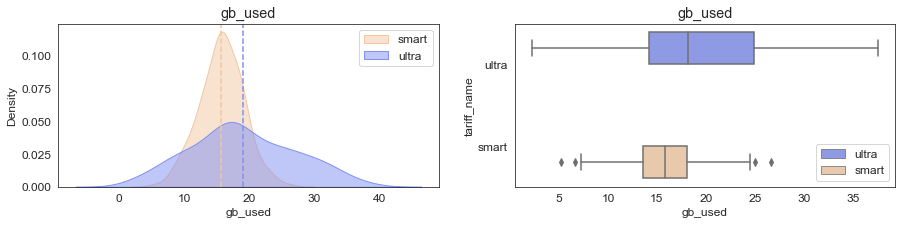

Amount of users who don't utilize this service: SMART - 0, ULTRA - 1


In [39]:
distribution('gb_used')

Tariff plans include 15 gb(SMART) and 30 gb(ULTRA)

**Internet:** 
1. SMART
    - Less than a half of smart users fit in to the internet plan of 15 gb, 
    - Median and mean usage is hiegher than plan for 900-800 mb,
    - Another quarter uses 16-18 gb, 
    - 25 gb would be exhaustively for the wast majority of the rest.

2. ULTRA
    - A half of ultra users monthly use below 18.2 gb, 
    - 75% fit in to the plan of 25 gb, 
    - 37 gb would be exhaustively for the wast majority of the rest.
3. Both tariffs have symmetrical distribution with a few extreme values. 
4. Ultra has a 135% higher deviation than Smart.

**SMS:**

,Total,SMART,ULTRA
median,38.0,33.8,57.3
mean,45.6,37.8,63.8
st.dev,33.6,24.8,43.2


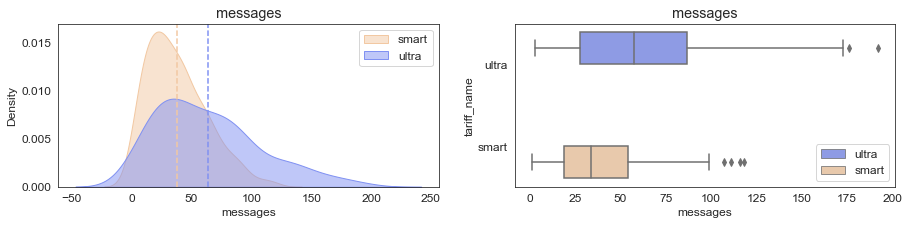

Amount of users who don't utilize this service: SMART - 44, ULTRA - 23


In [40]:
distribution('messages')

Tariff plans include 50 messages(SMART) and 1000 messages(ULTRA)

**Messages:**
1. SMART
    - 13.5% (44 users) dont send messages at all,
    - A half of smart users sands less than 35 messages per month, 
    - Another quarter sends 35-55 messages, 
    - 100 messages would be exhaustively for the wast majority of the rest.
    
2. ULTRA
    - 16.2% (23 users) dont send messages at all,
    - A half of smart users sands less than 60 messages per month, 
    - Another quarter sends 60-90 messages, 
    - 175 messages would be exhaustively for the wast majority of the rest.
    
3. Ultra has a 74% higher deviation than Smart.


<div class="alert alert-info">

**Inferences:**

1. Smart users regularly exceed their limits especialy it conserns to internet traffic.
2. The least demanded service is sms. 14.5% of all sample had never used it.
3. The most popular one is internet.
4. Ultra users fit within the all limits except internet:
    - 12% regularly exceed their limits,
    - 30.4% had exceded it at least once.
5. Ultra has more variability among values than Smart as its deviation always much higher

<a id="3"></a>

# 3. What is our revenue?

Total revenue from SMART: 2,881,050
Total revenue from ULTRA: 2,029,350


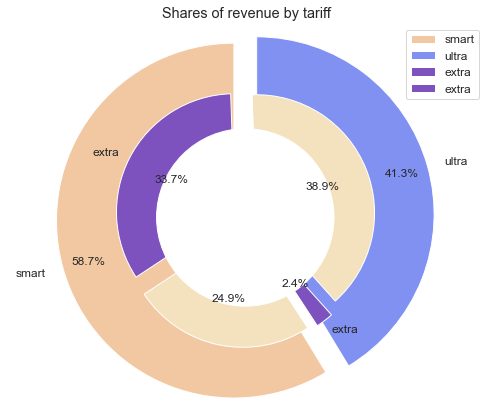

In [41]:
print('Total revenue from SMART: {:,.0f}' .format(data.query('tariff == "smart"')['total_fee'].sum()))
print('Total revenue from ULTRA: {:,.0f}' .format(data.query('tariff == "ultra"')['total_fee'].sum()))

tariff_revenue = data.groupby('tariff')['total_fee'].sum()
extra_fee = data.groupby('tariff').agg({'extra_fee':'sum', 'rub_monthly_fee': 'sum'})
extra_fee = extra_fee.reset_index().melt(id_vars= 'tariff', value_vars=['extra_fee', 'rub_monthly_fee'])\
            .groupby(['tariff', 'variable']).sum().reset_index()
extra_labels = ['extra', '', 'extra', '']
extra_colors = ['#7D52BF', '#F4E2BE']

plt.figure(figsize=(7, 6))
plt.pie(tariff_revenue, labels=tariff_revenue.index, colors = colors.values(), frame=True,
        startangle=90, explode=(0.2, 0.2), radius=3, pctdistance=0.85, autopct='%1.1f%%')
plt.pie(extra_fee['value'], labels= extra_labels, colors = extra_colors, 
        startangle=92, explode=(0.2, 0.2, 0.2, 0.2), radius=2, autopct='%1.1f%%')

centre_circle = plt.Circle((0,0),1.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Shares of revenue by tariff')
plt.axis('equal')
plt.tight_layout()
plt.legend()
plt.show()

Smart tariff with its 70% of sample brings 59% of revenue and most of it is extra payment for service not included in tariff package. We can make two conclusions of it:
1. it is high probability that middle user of smart tariff brings us less than ultra user (what logical because this tariff is almost 4 times cheaper). Below we will explore whether consumption is as high as revenue. 
2. such ammount of extra fee means that we have many users who isn't comfortable whith their package, but steel doesn't use enough to switch to Ultra(it shown by the fact that average smart user pays less). Neccecity to pay extra fees may irritate our users. Thus it looks like we should consider possibility to launch new tariff plan between Smart and Ultra or customized one.


**Total consumption by tariffs:**

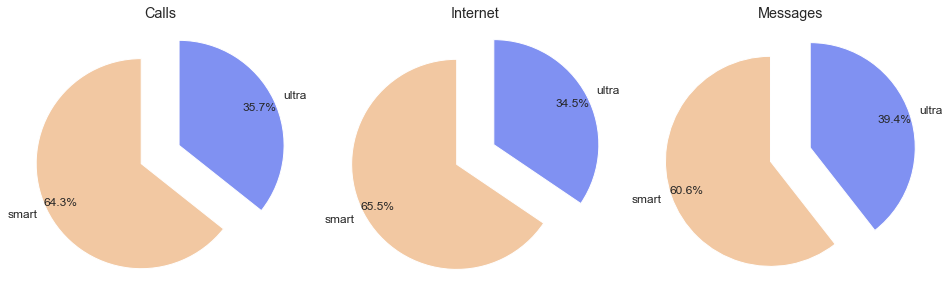

In [42]:
tariff_sum = data.groupby('tariff').agg({'min_used': 'sum', 'gb_used': 'sum', 'messages': 'sum'}).reset_index()

fig = plt.figure(figsize=(16, 8))
        
ax_1 = plt.subplot2grid((1,3),(0,0))
plt.pie(tariff_sum['min_used'], labels=tariff_sum['tariff'], colors = colors.values(), 
        startangle=90, explode=(0.2, 0.2),  pctdistance=0.85, autopct='%1.1f%%')
plt.title('Calls')

ax_2 = plt.subplot2grid((1,3),(0,1))
plt.pie(tariff_sum['gb_used'], labels=tariff_sum['tariff'], colors = colors.values(), 
        startangle=90, explode=(0.2, 0.2), pctdistance=0.85, autopct='%1.1f%%')
plt.title('Internet')

ax_3 = plt.subplot2grid((1,3),(0,2))
plt.pie(tariff_sum['messages'], labels=tariff_sum['tariff'], colors = colors.values(), 
        startangle=90, explode=(0.2, 0.2), pctdistance=0.85, autopct='%1.1f%%')
plt.title('Messages')

plt.show()

As we can see, shares of tariffs in consumption and revenue are a bit different. Ultra users spend less and give more revenue. The difference varies from 1.9 percentage points for sms to 5.pp for calls. In addition we spend less to to provide service for less subscribers in smart tariff. Without additional information about costs for connection, sim-cards and call center cervice it makes Ultra more attractive for us.

<div class="alert alert-success">
Let's briefly have a look at overpayments

Share of users who at least once overpayed: 96.6%
Median extra fee: 800


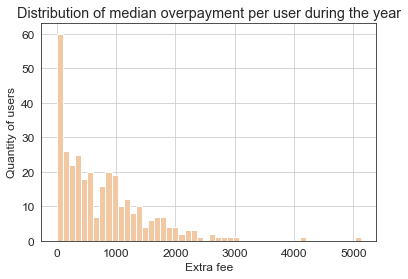

In [43]:
print('Share of users who at least once overpayed: {:.1%}' .format(data.query('extra_fee > 0 and tariff == "smart"')['user_id'].nunique() /
data.query('tariff == "smart"')['user_id'].nunique()))
print('Median extra fee: {:.0f}' .format(data.query('extra_fee > 0 and tariff == "smart"')['extra_fee'].median()))


data.query('tariff == "smart"').groupby('user_id').agg({'extra_fee': 'median'})['extra_fee']\
.hist(bins=50, color=colors['smart'])
plt.title('Distribution of median overpayment per user during the year')
plt.xlabel('Extra fee')
plt.ylabel('Quantity of users')
plt.show()

Now we can see that it's really ordinary to overpay for communication service. And there is a demand of new intermediate tariff among our users. But it's a subject of futher analisys.

<div class="alert alert-success">

<a id="4"></a>

# 4. Let's check the hipotesis.

<a id="4.1"></a>

## Does income between tariffs is different?

Smart tariff users: 325
Ultra tariff users: 142


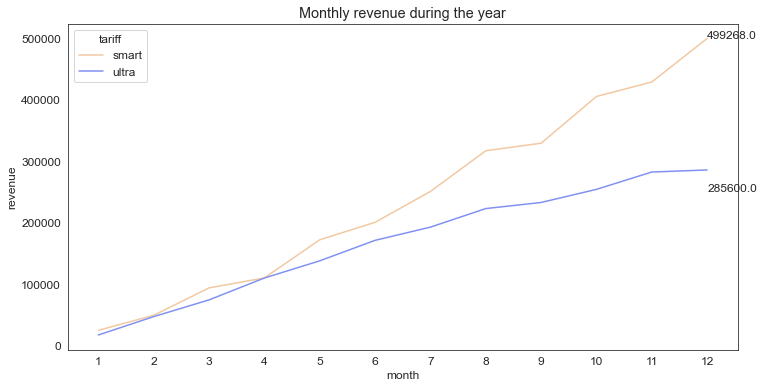

In [44]:
print('Smart tariff users:', users.query('tariff == "smart"')['user_id'].count())
print('Ultra tariff users:', users.query('tariff == "ultra"')['user_id'].count())
                                               
revenue = data.pivot_table(index=['month', 'tariff'], values='total_fee', aggfunc='sum').reset_index()

plt.figure(figsize=(12, 6))
revenue_plot = sns.lineplot(data=revenue, x='month',y = 'total_fee', hue='tariff', palette = colors)

plt.title('Monthly revenue during the year')
plt.ylabel('revenue')
plt.xticks(np.arange(1,13))
plt.annotate(data.query('tariff == "smart" and month == 12')['total_fee'].sum(), xy=(12, 500000), xytext=(12, 500000))
plt.annotate(data.query('tariff == "ultra" and month == 12')['total_fee'].sum(), xy=(12, 250000), xytext=(12, 250000))

plt.show()

**In december revenue from Smart exceeded revenue from Ultra by 75%**

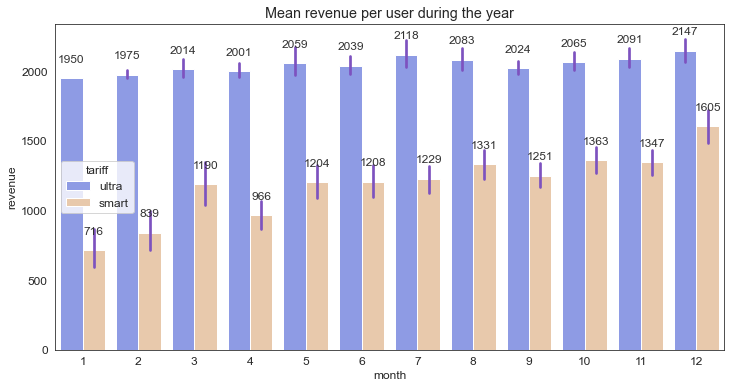

In [45]:
plt.figure(figsize=(12, 6))
revenue_pu_plot = sns.barplot(data=data, x='month',y = 'total_fee', hue='tariff', palette = colors,errcolor='#7D52BF')

for i in revenue_pu_plot.patches:
    height = i.get_height()
    revenue_pu_plot.text(i.get_x() + i.get_width()/2, height+100, int(height), ha='center', va='bottom', c='#323232')

plt.title('Mean revenue per user during the year')
plt.ylabel('revenue')
plt.show()

The graph shows that the revenue between tariffs is different. Let's verify whether it is so with statistics test.

**Let's survey extreme values:**

In [46]:
smart_revenue = data.query('tariff == "smart"')['total_fee']
ultra_revenue = data.query('tariff == "ultra"')['total_fee']

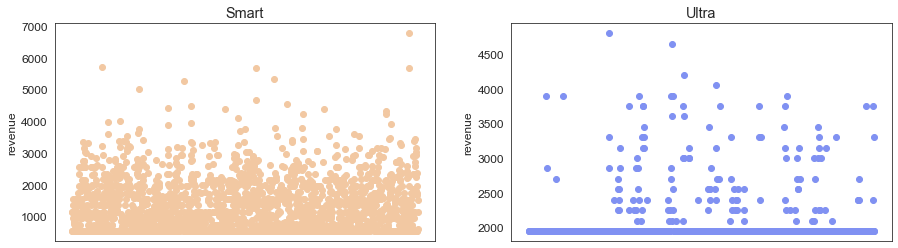

In [47]:
x_val_revenue_s = pd.Series(range(0, len(smart_revenue)))
x_val_revenue_u = pd.Series(range(0, len(ultra_revenue)))

fig = plt.figure(figsize=(15, 4))
        
ax_1 = fig.add_subplot(1, 2, 1)
plt.scatter(x_val_revenue_s, smart_revenue, color = colors['smart'])
plt.ylabel('revenue')
plt.title('Smart')
plt.xticks([])

ax_2 = fig.add_subplot(1, 2, 2)
plt.scatter(x_val_revenue_u, ultra_revenue, color = colors['ultra'])
plt.ylabel('revenue')
plt.title('Ultra')
plt.xticks([])
plt.show()

As we can see, we have numerous extreme values. Therefore we will use Mann Whitney test instead of Students t-tess. If the resuls is controversial we will double check with clean data and t-test.

In [48]:
result1 = st.mannwhitneyu(smart_revenue, ultra_revenue)
if result1.pvalue > 0.05:
    print('We do not reject the hypothesis that the revenue between tariffs is the same, pvalue =', result1.pvalue)
else:
    print('We can reject the hypothesis that the revenue between tariffs is the same, pvalue =', result1.pvalue)

We can reject the hypothesis that the revenue between tariffs is the same, pvalue = 2.0512772292540072e-184


<div class="alert alert-info">
    
**Inferences:**

We could see that by december revenue from Smart exceeded revenue from Ultra by 75%. That superiority must have been caused by a grater number of Smart users as we also saw that mean revenue per Ultra user is notisably higher in spite of the constant extra fees in Smart tariff. 
We also rejected the null hipothesis about equality of revenue between the tariffs with the Mann Whithney test. 

<a id="4.2"></a>

## Does income between Moscow and other regions is different?

In [49]:
moscow = 'Москва'

data['moscow'] = data['region'].apply(lambda x: True if x == moscow else False)

Amount of users in Moscow:  92
Amount of users in other regions:  371


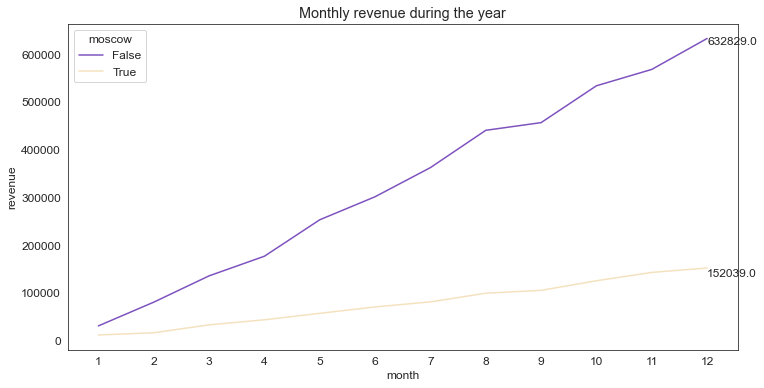

In [50]:
print('Amount of users in Moscow: ', users.query('region == @moscow')['user_id'].nunique())
print('Amount of users in other regions: ', users.query('region != @moscow')['user_id'].nunique())

revenue_reg = data.pivot_table(index=['month', 'moscow'], values='total_fee', aggfunc='sum').reset_index()

plt.figure(figsize=(12, 6))
revenue_reg_plot = sns.lineplot(data=revenue_reg, x='month',y = 'total_fee', hue='moscow', palette = extra_colors)

plt.title('Monthly revenue during the year')
plt.ylabel('revenue')
plt.xticks(np.arange(1,13))
plt.annotate(data.query('region == @moscow and month == 12')['total_fee'].sum(), xy=(12, 135000), xytext=(12, 135000))
plt.annotate(data.query('region != @moscow and month == 12')['total_fee'].sum(), xy=(12, 620000), xytext=(12, 620000))
plt.show()

As we can see monthly revenue from region users is much higher, but also we should consider the fact that we have 4 times less users from Moscow.

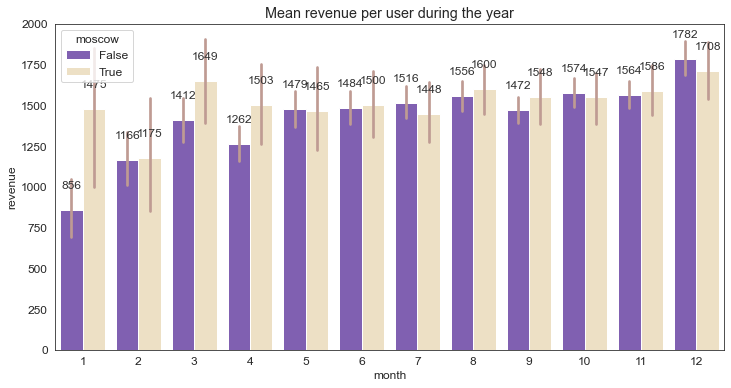

In [51]:
plt.figure(figsize=(12, 6))
revenue_pu_reg_plot = sns.barplot(data=data, x='month',y = 'total_fee', hue='moscow', palette = extra_colors, errcolor='#BF9B93')

for i in revenue_pu_reg_plot.patches:
    height = i.get_height()
    revenue_pu_reg_plot.text(i.get_x() + i.get_width()/2, height+120, int(height), ha='center', va='bottom', c='#323232')

plt.title('Mean revenue per user during the year')
plt.ylabel('revenue')
plt.show()

Starting with May revenue per user is constantly comparable. Also we can see that Moscow users have more variability. Let's verify whether it is so with statistics test.

**Let's survey extreme values:**

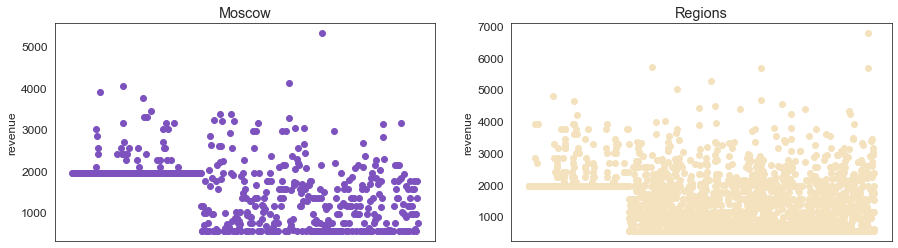

In [52]:
moscow_revenue = data.query('region == @moscow')['total_fee']
region_revenue = data.query('region != @moscow')['total_fee']

x_val_revenue_m = pd.Series(range(0, len(moscow_revenue)))
x_val_revenue_r = pd.Series(range(0, len(region_revenue)))

fig = plt.figure(figsize=(15, 4))
        
ax_1 = fig.add_subplot(1, 2, 1)
plt.scatter(x_val_revenue_m, moscow_revenue, color = '#7D52BF')
plt.ylabel('revenue')
plt.title('Moscow')
plt.xticks([])

ax_2 = fig.add_subplot(1, 2, 2)
plt.scatter(x_val_revenue_r, region_revenue, color = '#F4E2BE')
plt.ylabel('revenue')
plt.title('Regions')
plt.xticks([])
plt.show()

As we can see, we have numerous extreme values. Therefore we will use Mann Whitney test instead of Students t-tess. If the resuls is controversial we will double check with clean data and t-test.

In [53]:
result2 = st.mannwhitneyu(moscow_revenue, region_revenue)
if result2.pvalue > 0.05:
    print('We do not reject the null hypothesis that the revenue between Moscow and regions is the same, pvalue =', result2.pvalue)
else:
    print('We can reject the null hypothesis that the revenue between  Moscow and regions is the same, pvalue =', result2.pvalue)

We do not reject the null hypothesis that the revenue between Moscow and regions is the same, pvalue = 0.13121123315524919


<div class="alert alert-info">
    
**Inferences:**
    
Data shows us that total monthly revenue from region users is much higher (we have 4 times less users from Moscow than from regions). Revenue per user looks comparable but with larger viriativity in Moscow, although the share of Moscow is larger in Ultra subscribers. Results of Mann Whithney test don't alow us to reject hipotesys about equality of revenue between Moscow and regions as well.

<a id="5"></a>

# Key findings

1. Our users:
    1. Age distribution is uniform for both tariffs(there are ages between 18 and 75 in our sample).
    2. More than 20% of all Ultra users based in Moscow.
    3. Regional distribution of the Smart users is similar to population distribution by regions.
2. Users behavior:
    1. Smart users regularly exceed their limits especialy it conserns to internet traffic.
    2. The least demanded service is sms. 14.5% of all sample had never used it.
    3. The most popular one is internet.
    4. Ultra users fit within the all limits except internet:
        - 12% regularly exceed their limits,
        - 30.4% had exceded it at least once.
    5. Ultra has more variability among values than Smart as its deviation always much higher
3. Smart tariff with its 70% of sample brings 59% of revenue and most of it is extra payment for service not included in tariff package(57% of all Smart revenue). 
4. By december revenue from Smart exceeded revenue from Ultra by 75%. That superiority must have been caused by a grater number of Smart users (128% more) as we also saw that mean revenue per Ultra user is notisably higher by 64-75%. Having such difference to maintain equal revenue from two tariffs quantity of Smart users has to exceed at least by 45-50%. 
We also rejected the null hipothesis about equality of revenue between the tariffs with the Mann Whithney test. 
5. As shares of tariffs in consumption and revenue are a bit different. Ultra users spend less and give more revenue. The difference varies from 1.9 percentage points for sms to 5.pp for calls. In addition we spend less to to provide service for less subscribers in smart tariff. **Without additional information about costs for connection, sim-cards and call center cervice it makes Ultra more attractive for us.**
But we should remember that such a difference between tariffs fees (64-75%) can barely allow us to make Ultra as mass as Smart.
5. Total monthly revenue from region users is much higher than from Moscow users (we have 4 times less users from Moscow than from regions). Mean revenue per user is comparable with larger viriativity in Moscow. Results of Mann Whithney test don't alow us to reject hipotesys about equality of revenue between Moscow and regions as well.
6. In addition I would recommend to consider possibility for launching new tariff plan between Smart and Ultra or customized one. As the neccecity to pay such amount extra fees may irritate users of Smart tariff.